# Set up

In [1]:
import numpy as np
import pandas as pd
import sys
import importlib
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
# setup path to directories where data are stored
HomeDir = './'
DataDir = '/Users/crimondino/Dropbox (PI)/LensVelocity2/data/star_star/' 

# Read in raw data and perform astrometic quality and distance cuts

In [3]:
# read in the clean data files (after the ruwe and distance cuts)
df_fore = pd.read_csv(DataDir+'fg_subtracted.csv', usecols = ['source_id', 'phot_g_mean_mag', 'dist_50'])
df_back = pd.read_csv(DataDir+'bg_subtracted.csv', usecols = ['source_id', 'phot_g_mean_mag'])
len(df_back), len(df_fore)

(11690246, 11690246)

In [4]:
# select only lenses that are closer than 300 pc
select = df_fore['dist_50'] < 300
df_fore = df_fore[select]
df_back = df_back[select]
len(df_back)

813801

In [5]:
df_fore.to_csv(DataDir+'fg_subtracted_dist300.csv', index=False)
df_back.to_csv(DataDir+'bg_subtracted_dist300.csv', index=False)

In [155]:
# Login to Gaia server, username and passwd saved in a txt file
Gaia.login(credentials_file='/Users/crimondino/Dropbox (PI)/MyLensVelocity2/files/my_gaia_credentials.txt')

OK


In [157]:
# Upload the csv file as a table on the Gaia server. I call the table 'table_background_dr3'
#job = Gaia.upload_table(upload_resource=DataDir+'fg_subtracted_dist300.csv', table_name="foreground_stars", format="csv")
job = Gaia.upload_table(upload_resource=DataDir+'bg_subtracted_dist300.csv', table_name="background_stars", format="csv")

Sending file: /Users/crimondino/Dropbox (PI)/LensVelocity2/data/star_star/bg_subtracted_dist300.csv
Uploaded table 'background_stars'.


In [156]:
# Printing a list of the available table. Notice that the table that I just uploaded is available as 'user_cmondino.table_background_dr3'
# The distance catalogue is also available as external.gaiaedr3_distance
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print(table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.catwise2020
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1

In [14]:
# Query based on source_id. This is a bit complicated because I need to query based both on EDR3 source_id and DR2 source_id. But in our case we'll need to query only the external.gaiaedr3_distance table

full_qualified_table_name = 'user_cmondino.foreground_stars'

str_1 = "SELECT g3.source_id, g3.bp_rp FROM gaiaedr3.gaia_source AS g3 "
str_2 = "JOIN " + full_qualified_table_name + " AS fg ON g3.source_id = fg.source_id"

str_job = str_1+str_2

print(str_job)

job = Gaia.launch_job_async(str_job, output_file=DataDir+'fg_bprp.csv',output_format='csv',dump_to_file=True,background=False);
print(job)

SELECT g3.source_id, g3.bp_rp FROM gaiaedr3.gaia_source AS g3 JOIN user_cmondino.foreground_stars AS fg ON g3.source_id = fg.source_id
Jobid: 1706283384803O
Phase: COMPLETED
Owner: None
Output file: /Users/crimondino/Dropbox (PI)/LensVelocity2/data/star_star/fg_bprp.csv
Results: None


In [158]:
# Query based on source_id. This is a bit complicated because I need to query based both on EDR3 source_id and DR2 source_id. But in our case we'll need to query only the external.gaiaedr3_distance table

full_qualified_table_name = 'user_cmondino.background_stars'

str_1 = "SELECT g3.source_id, g3.bp_rp, g3.astrometric_sigma5d_max, g3.phot_g_mean_flux FROM gaiaedr3.gaia_source AS g3 "
str_2 = "JOIN " + full_qualified_table_name + " AS bg ON g3.source_id = bg.source_id"

str_job = str_1+str_2

print(str_job)

job = Gaia.launch_job_async(str_job, output_file=DataDir+'bg_bprp.csv',output_format='csv',dump_to_file=True,background=False);
print(job)

SELECT g3.source_id, g3.bp_rp, g3.astrometric_sigma5d_max, g3.phot_g_mean_flux FROM gaiaedr3.gaia_source AS g3 JOIN user_cmondino.background_stars AS bg ON g3.source_id = bg.source_id
Jobid: 1706293906954O
Phase: COMPLETED
Owner: None
Output file: /Users/crimondino/Dropbox (PI)/LensVelocity2/data/star_star/bg_bprp.csv
Results: None


In [159]:
# Delete the table created and logout
job = Gaia.delete_user_table("foreground_stars")
job = Gaia.delete_user_table("background_stars")

500 Error 500:
Can not execute the following SQL: 
DROP TABLE user_cmondino.foreground_stars
Because: ERROR: table "foreground_stars" does not exist


HTTPError: Error 500:
Can not execute the following SQL: 
DROP TABLE user_cmondino.foreground_stars
Because: ERROR: table "foreground_stars" does not exist

In [160]:
Gaia.logout()

# Check contamination from partally resolved binaries

In [276]:
# for plots
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

FigDir = './figures/'

In [286]:
# read in the clean data files (after the ruwe and distance cuts)
df_fore = pd.read_csv(DataDir+'fg_subtracted_dist300.csv', usecols = ['source_id', 'phot_g_mean_mag', 'dist_50'])
df_back = pd.read_csv(DataDir+'bg_subtracted_dist300.csv', usecols = ['source_id', 'phot_g_mean_mag'])
len(df_back), len(df_fore)

(813801, 813801)

In [287]:
# read in bp-rp color
df_fore_bprp = pd.read_csv(DataDir+'fg_bprp.csv', usecols = ['source_id', 'bp_rp'])
df_back_bprp = pd.read_csv(DataDir+'bg_bprp.csv', usecols = ['source_id', 'bp_rp', 'astrometric_sigma5d_max', 'phot_g_mean_flux'])
len(df_back), len(df_fore)

(813801, 813801)

In [288]:
# check on the source id
df_fore[['source_id_c', 'bp_rp']] = df_fore_bprp[['source_id', 'bp_rp']]
df_back[['source_id_c', 'bp_rp', 'astrometric_sigma5d_max']] = df_back_bprp[['source_id', 'bp_rp', 'astrometric_sigma5d_max']]
df_fore['source_id'].equals(df_fore['source_id_c']), df_back['source_id'].equals(df_back['source_id_c'])

(True, True)

In [289]:
df_fore['g_mag_diff'] = (df_back['phot_g_mean_mag']-df_fore['phot_g_mean_mag'])
df_fore['color_diff'] = (df_back['bp_rp'] - df_fore['bp_rp'])
df_fore['phot_g_mean_mag_back'] = df_back['phot_g_mean_mag']
df_fore['bp_rp_back'] = df_back['bp_rp']
df_fore['astrometric_sigma5d_max'] = df_back['astrometric_sigma5d_max']

In [298]:
def gammaG(G):
    return np.max(np.array([np.ones(len(G)), 10**(0.2*(G-18))]).T, axis=1)

df_fore['Psi'] = df_fore['astrometric_sigma5d_max']/(1.2*gammaG(df_fore['phot_g_mean_mag_back'].to_numpy()))

In [299]:
g_mag_bins = np.array([3.4, 16.1, 17.4, 18.2, 18.8, 19.3, 19.7, 20.0, 20.4, 20.7, 21])
df_fore['g_mag_i'] = np.digitize(df_fore['phot_g_mean_mag_back'].to_numpy(), g_mag_bins) - 1 

In [311]:
df_plot = df_fore[~df_fore['color_diff'].isna()]
len(df_plot)/len(df_fore)

0.3560120963233026

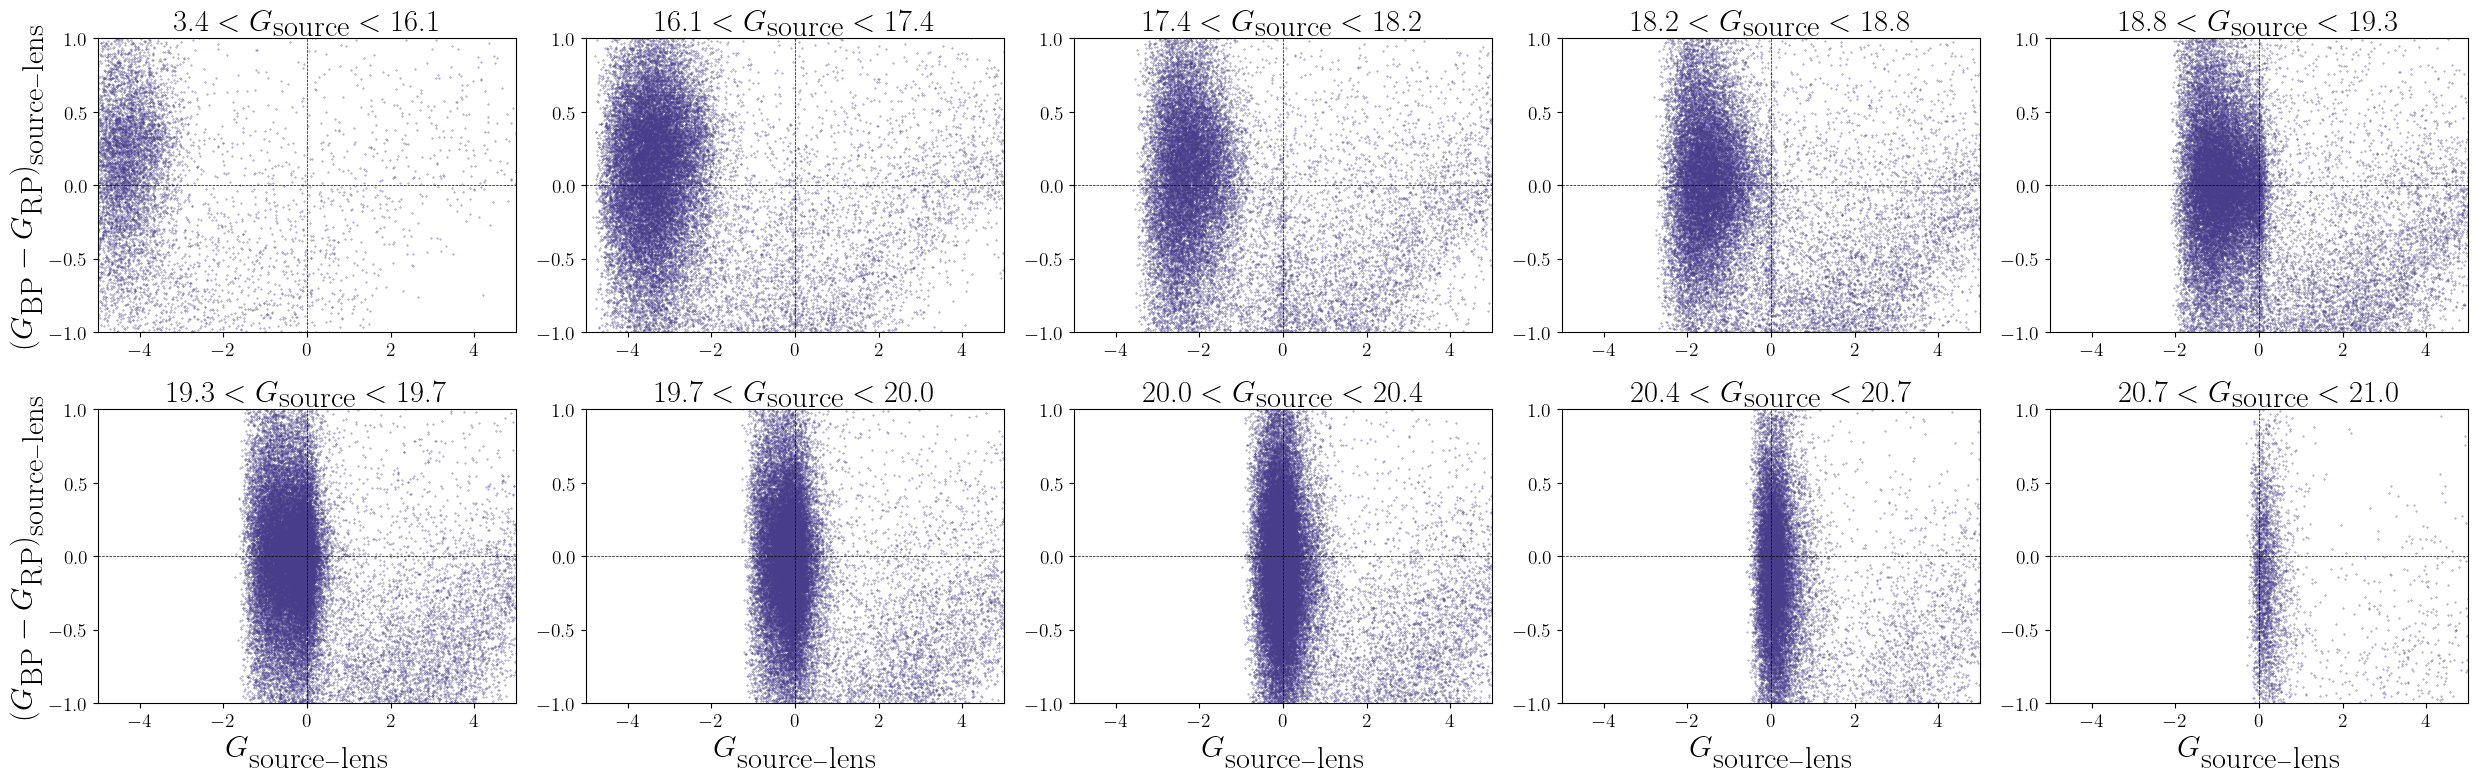

In [301]:
# Group by 'Category' column
grouped = df_plot.groupby('g_mag_i')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,8))

# Create scatter plots for each group
for i_row in range(2):
    for i_col in range(5):
        name=i_row*5+i_col    
        group=grouped.get_group(name)

        ax[i_row][i_col].scatter(group['g_mag_diff'], group['color_diff'], label=name, s=0.1, c='darkslateblue', alpha=0.8)
        ax[i_row][i_col].axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax[i_row][i_col].axvline(0, color='black', linestyle='--', linewidth=0.5)

        ax[i_row][i_col].set_xlim(-5,5)
        ax[i_row][i_col].set_ylim(-1,1)
        ax[i_row][i_col].set_title(str(g_mag_bins[int(name)])+r' $< G_{\textrm{source}} <$ '+str(g_mag_bins[int(name)+1]), fontsize=22)

        ax[1][i_col].set_xlabel(r'$G_{\textrm{source}-\textrm{lens}}$', fontsize=22)
    ax[i_row][0].set_ylabel(r'$(G_{\textrm{BP}}-G_{\textrm{RP}})_{\textrm{source}-\textrm{lens}}$', fontsize=22);
    
fig.tight_layout()
#fig.savefig(FigDir+'photo_pairs.png')

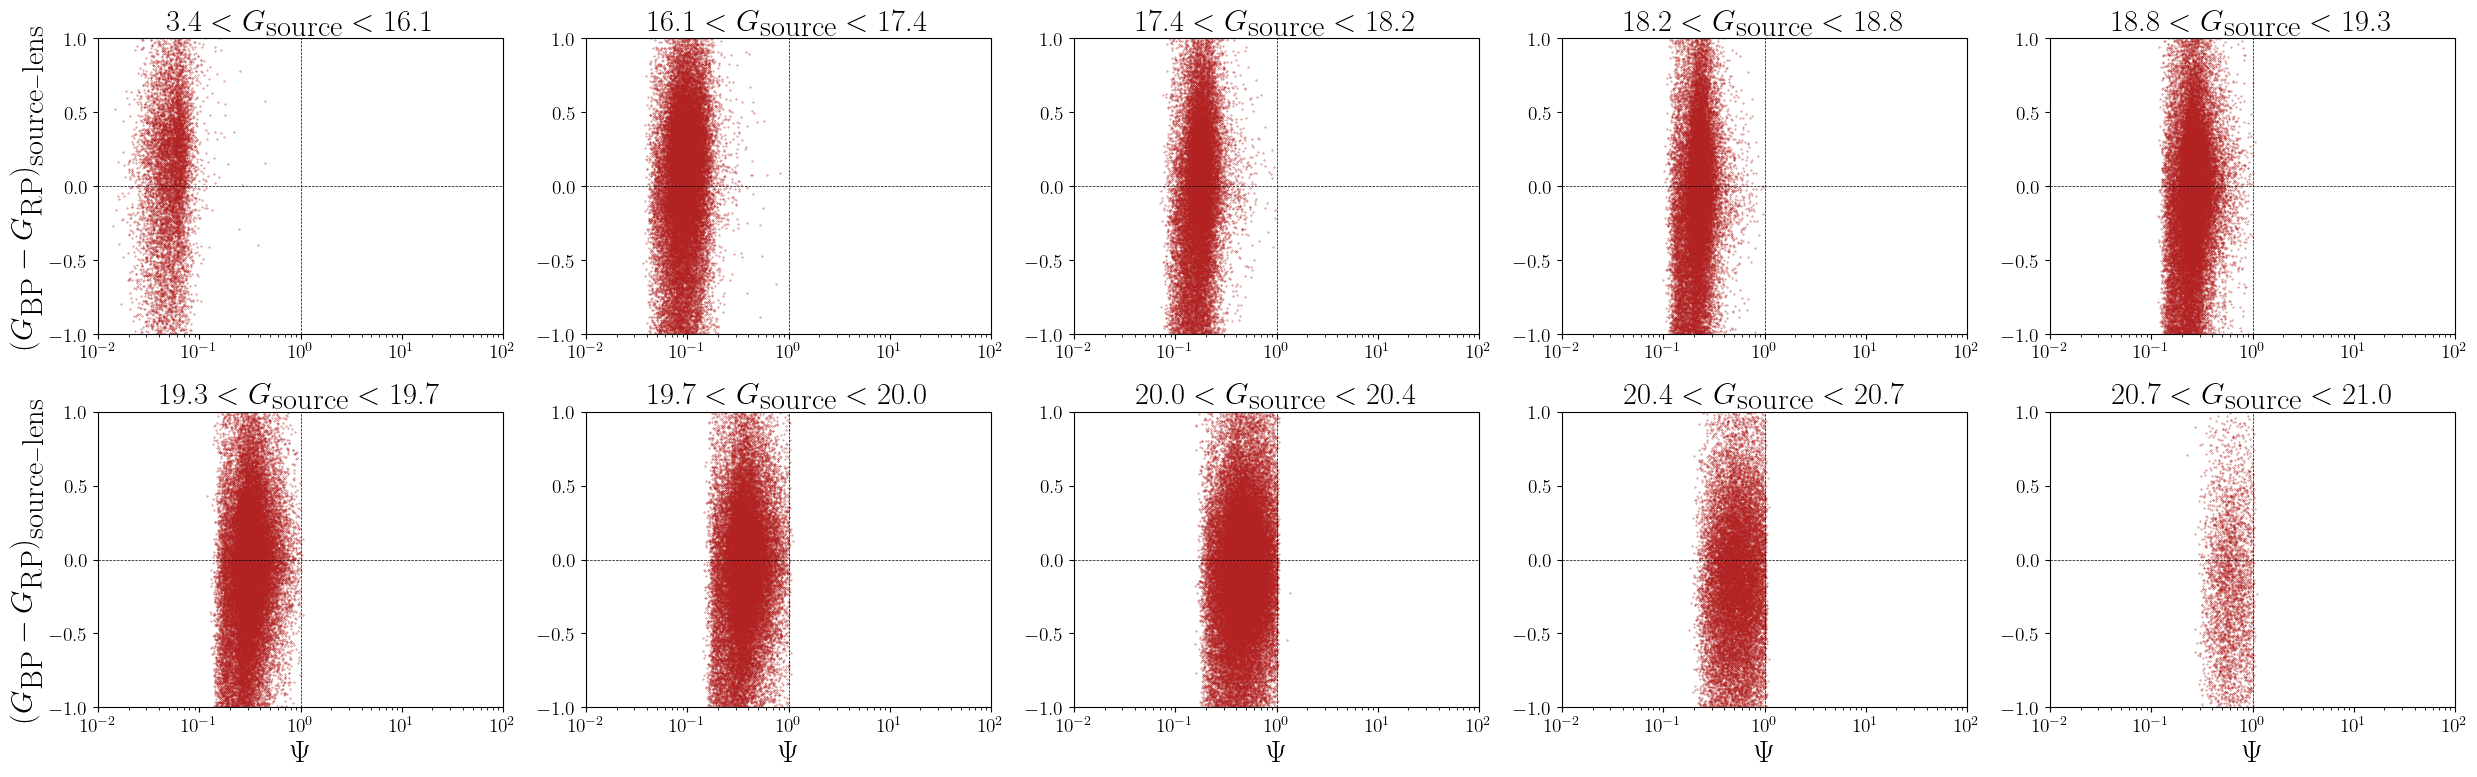

In [302]:
# Group by 'Category' column
grouped = df_plot.groupby('g_mag_i')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,8))

# Create scatter plots for each group
#for name, group in grouped:
for i_row in range(2):
    for i_col in range(5):
        name=i_row*5+i_col    
        group=grouped.get_group(name)
    
        ax[i_row][i_col].scatter(group['Psi'], group['color_diff'], label=name, s=0.1, c='firebrick', alpha=0.8)
        ax[i_row][i_col].axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax[i_row][i_col].axvline(1, color='black', linestyle='--', linewidth=0.5)

        ax[i_row][i_col].set_xscale('log')
        ax[i_row][i_col].set_xlim(0.01,100)
        ax[i_row][i_col].set_ylim(-1,1)
        ax[i_row][i_col].set_title(str(g_mag_bins[int(name)])+r' $< G_{\textrm{source}} <$ '+str(g_mag_bins[int(name)+1]), fontsize=22)

        ax[1][i_col].set_xlabel(r'$\Psi$', fontsize=22)    
    ax[i_row][0].set_ylabel(r'$(G_{\textrm{BP}}-G_{\textrm{RP}})_{\textrm{source}-\textrm{lens}}$', fontsize=22);
    
fig.tight_layout()
#fig.savefig(FigDir+'photo_pairs_psi.png')

In [308]:
df_plot = df_fore[~df_fore['phot_g_mean_mag'].isna()]
len(df_plot)/len(df_fore)

0.9943708597064884

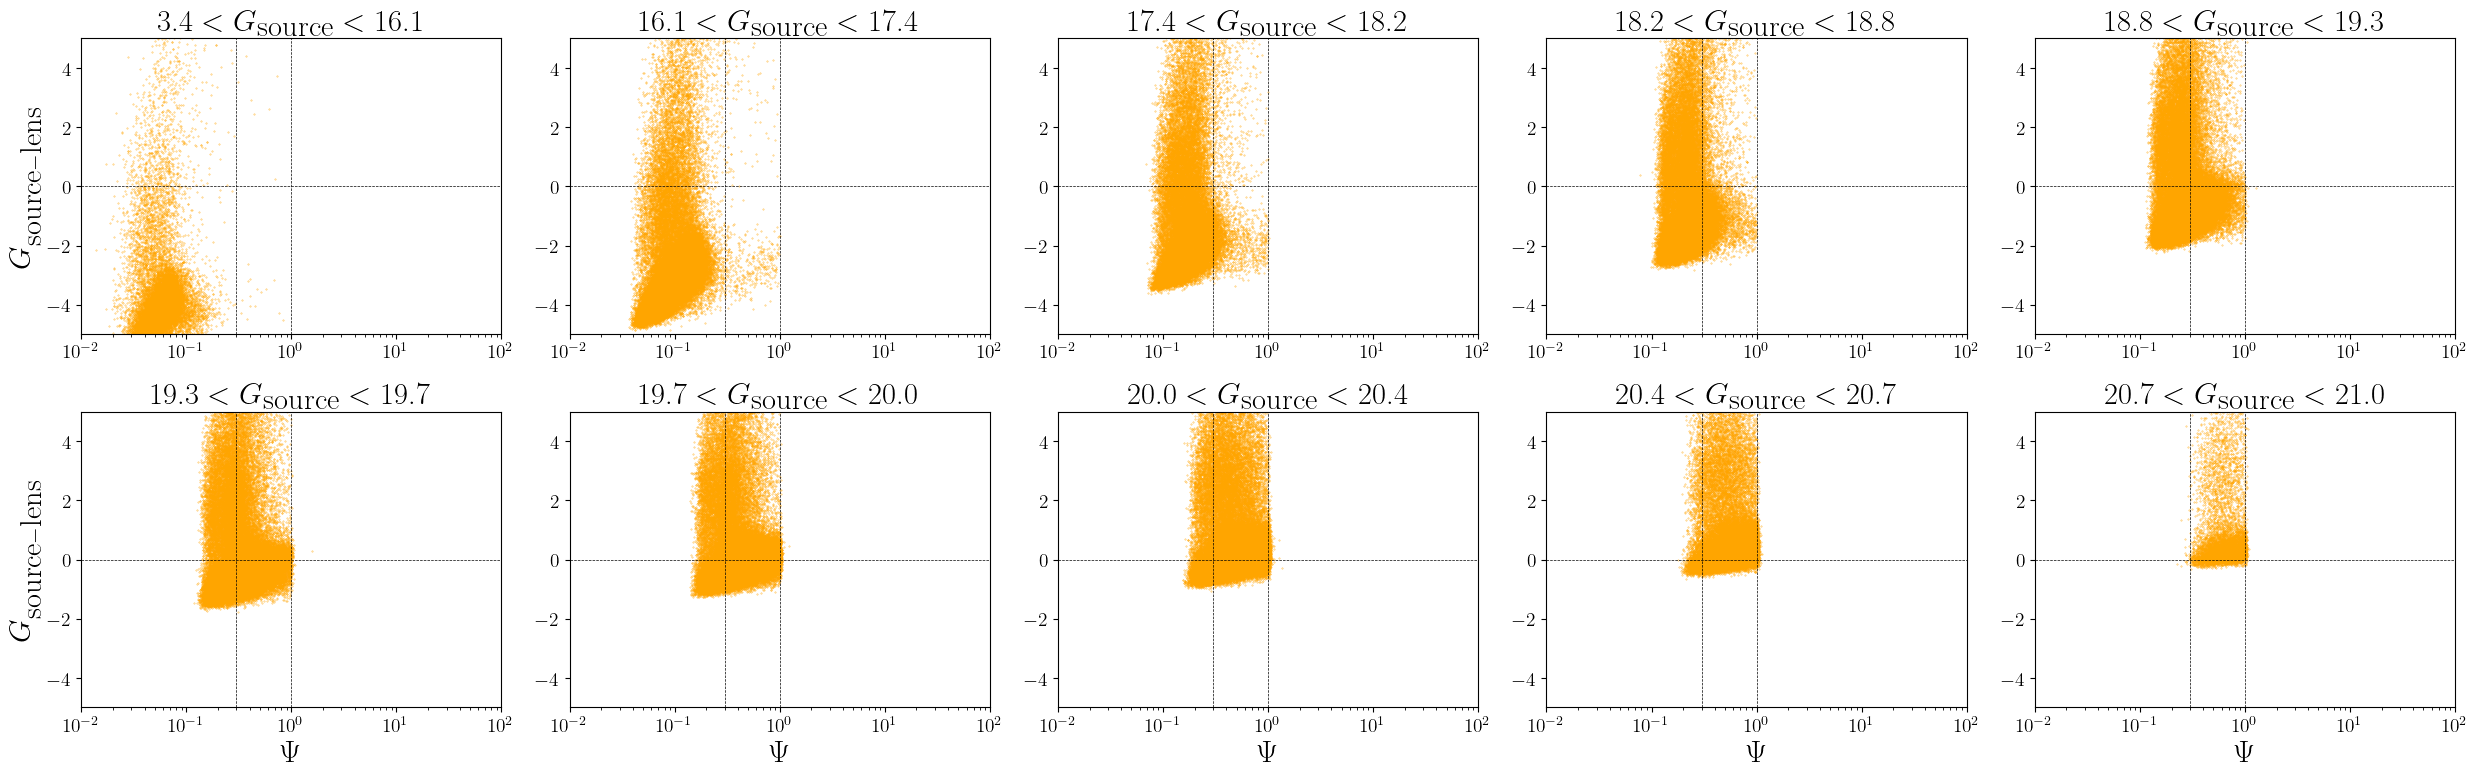

In [306]:
# Group by 'Category' column
grouped = df_fore.groupby('g_mag_i')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,8))

# Create scatter plots for each group
#for name, group in grouped:
for i_row in range(2):
    for i_col in range(5):
        name=i_row*5+i_col    
        group=grouped.get_group(name)
    
        ax[i_row][i_col].scatter(group['Psi'], group['g_mag_diff'], label=name, s=0.1, c='orange', alpha=0.8)
        ax[i_row][i_col].axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax[i_row][i_col].axvline(1, color='black', linestyle='--', linewidth=0.5)
        ax[i_row][i_col].axvline(0.3, color='black', linestyle='--', linewidth=0.5)

        ax[i_row][i_col].set_xscale('log')
        ax[i_row][i_col].set_xlim(0.01,100)
        ax[i_row][i_col].set_ylim(-5,5)
        ax[i_row][i_col].set_title(str(g_mag_bins[int(name)])+r' $< G_{\textrm{source}} <$ '+str(g_mag_bins[int(name)+1]), fontsize=22)

        ax[1][i_col].set_xlabel(r'$\Psi$', fontsize=22)    
    ax[i_row][0].set_ylabel(r'$G_{\textrm{source}-\textrm{lens}}$', fontsize=22);
    
fig.tight_layout()
fig.savefig(FigDir+'photo_pairs_nocolor.png')

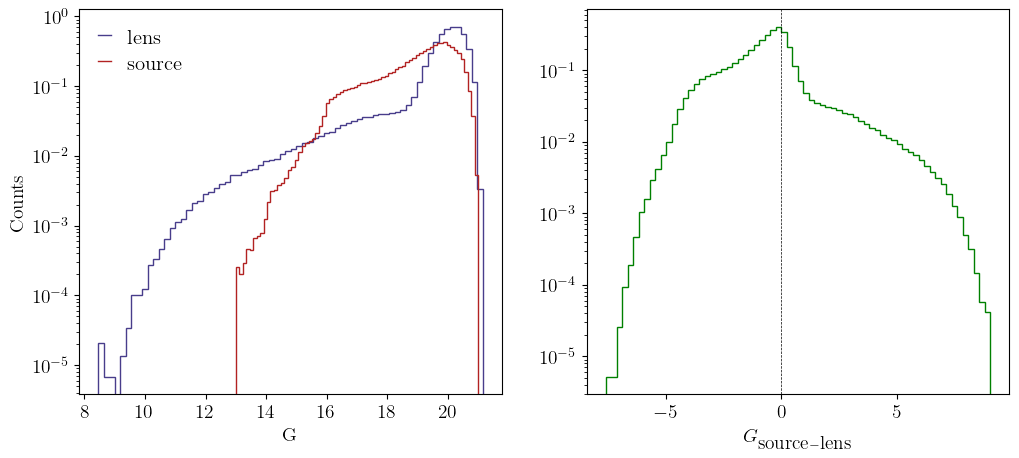

In [213]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']

custom_lines = [mpl.lines.Line2D([0], [0], c=colorlist[0], lw=1, label='lens'),
                mpl.lines.Line2D([0], [0], c=colorlist[1], lw=1, label='source')]

ax[0].hist(df_fore['phot_g_mean_mag'].to_numpy(), bins=70, log=True, density=True, histtype='step', color=colorlist[0], linewidth=1);
ax[0].hist(df_fore['phot_g_mean_mag_back'].to_numpy(), bins=70, log=True, density=True, histtype='step', color=colorlist[1], linewidth=1);

ax[0].legend(custom_lines, ['lens', 'source'],  frameon=False, fontsize=15, handlelength=0.6, labelspacing=0.3)
ax[0].set_xlabel('G'); ax[0].set_ylabel('Counts');

ax[1].hist(df_fore['phot_g_mean_mag_back']-df_fore['phot_g_mean_mag'], bins=70, log=True, density=True, histtype='step', color=colorlist[2], linewidth=1);
ax[1].axvline(0, color='black', linestyle='--', linewidth=0.5)
ax[1].set_xlabel(r'$G_{\textrm{source}-\textrm{lens}}$'); 

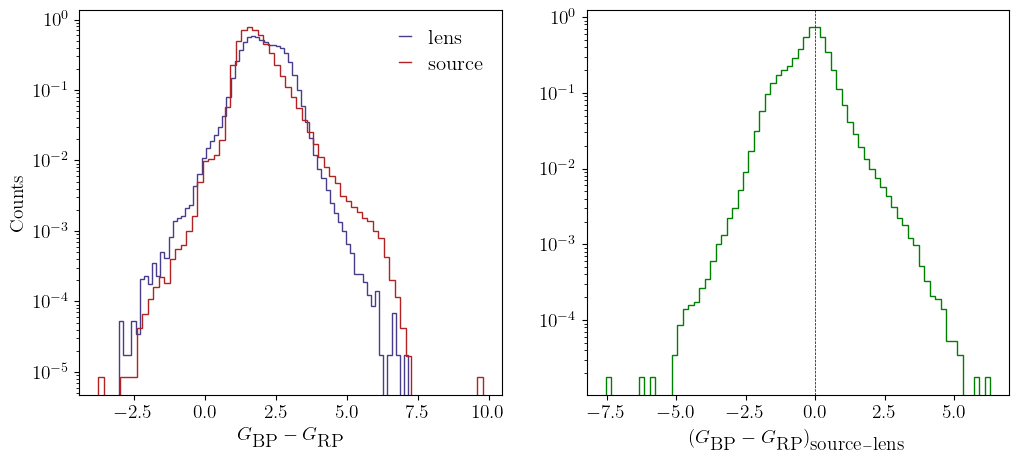

In [154]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange', 'black', 'purple']

custom_lines = [mpl.lines.Line2D([0], [0], c=colorlist[0], lw=1, label='lens'),
                mpl.lines.Line2D([0], [0], c=colorlist[1], lw=1, label='source')]

ax[0].hist(df_fore['bp_rp'].to_numpy(), bins=70, log=True, density=True, histtype='step', color=colorlist[0], linewidth=1);
ax[0].hist(df_fore['bp_rp_back'].to_numpy(), bins=70, log=True, density=True, histtype='step', color=colorlist[1], linewidth=1);

ax[0].legend(custom_lines, ['lens', 'source'],  frameon=False, fontsize=15, handlelength=0.6, labelspacing=0.3)
ax[0].set_xlabel(r'$G_{\textrm{BP}}-G_{\textrm{RP}}$'); ax[0].set_ylabel('Counts');

ax[1].hist(df_fore['bp_rp_back']-df_fore['bp_rp'], bins=70, log=True, density=True, histtype='step', color=colorlist[2], linewidth=1);
ax[1].axvline(0, color='black', linestyle='--', linewidth=0.5)
ax[1].set_xlabel(r'$(G_{\textrm{BP}}-G_{\textrm{RP}})_{\textrm{source}-\textrm{lens}}$'); 

In [275]:
# Check that there are no repeated foreground-background stellar pairs

def check_pair_uniqueness(arr):
    seen_pairs = set()

    for pair in arr:
        # Convert the row to a tuple to make it hashable
        pair_tuple = tuple(pair)

        # Check if the pair is already seen
        if pair_tuple in seen_pairs:
            print(f"Pair {pair} is repeated.")
        else:
            seen_pairs.add(pair_tuple)
            #print(f"Pair {pair} is unique.")

# Example usage:
array_of_pairs = np.array([df_fore.source_id, df_back.source_id]).T
check_pair_uniqueness(array_of_pairs)